# Pretrained Xception - Keras

## Feature extraction

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

### Compatibility issues

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Preprocess data

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_dir = '/home/carlo/Documentos/Datasets/chest_xray/train'
test_dir = '/home/carlo/Documentos/Datasets/chest_xray/test'
val_dir = '/home/carlo/Documentos/Datasets/chest_xray/val'

In [5]:
IMAGE_SIZE = 299
batch_size = 4

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Import and load Xception

In [6]:
conv_base = Xception(
    include_top=False,
    weights='imagenet'
)
conv_base.trainable = False
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [7]:
model = Sequential()
model.add(conv_base)

model.add(GlobalAvgPool2D())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [8]:
lr = 1e-4
epochs = 50
patience = 5
steps_per_epoch = 1760
validation_steps = 16

In [9]:
from tensorflow.keras.optimizers import Nadam
opt = Nadam(lr)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor='accuracy',
    patience=patience,
    restore_best_weights=True
)

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[earlyStopping]
)

Epoch 1/50
1760/1760 [==============================] - 284s 161ms/step - loss: 0.4819 - accuracy: 0.7598 - val_loss: 0.6533 - val_accuracy: 0.5000
Epoch 2/50
1760/1760 [==============================] - 281s 159ms/step - loss: 0.3892 - accuracy: 0.8286 - val_loss: 0.6665 - val_accuracy: 0.5000
Epoch 3/50
1760/1760 [==============================] - 280s 159ms/step - loss: 0.3577 - accuracy: 0.8486 - val_loss: 0.7884 - val_accuracy: 0.5000
Epoch 4/50
1760/1760 [==============================] - 281s 160ms/step - loss: 0.3311 - accuracy: 0.8601 - val_loss: 0.7876 - val_accuracy: 0.5000
Epoch 5/50
1760/1760 [==============================] - 282s 160ms/step - loss: 0.3249 - accuracy: 0.8624 - val_loss: 0.8310 - val_accuracy: 0.5000
Epoch 6/50
1760/1760 [==============================] - 272s 154ms/step - loss: 0.3107 - accuracy: 0.8690 - val_loss: 0.8181 - val_accuracy: 0.5000
Epoch 7/50
1760/1760 [==============================] - 275s 156ms/step - loss: 0.3092 - accuracy: 0.8746 - val_

In [12]:
model.save('xception.h5')

### Plot the results

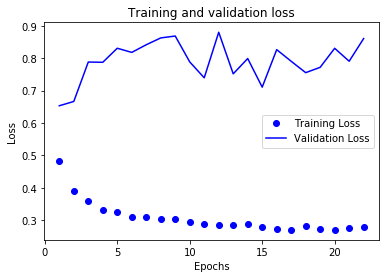

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss') #bo es para blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss') # b es para solid blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

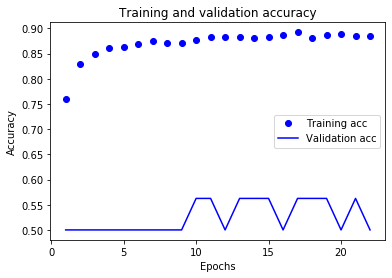

In [14]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Fine tunning

In [22]:
conv_base.trainable = True
epochs = 50

lr = 1e-6
opt = Nadam(lr)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
earlyStopping = EarlyStopping(
    monitor='accuracy',
    patience=patience,
    restore_best_weights=True
)

In [24]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[earlyStopping]
)

Epoch 1/50
1760/1760 [==============================] - 693s 394ms/step - loss: 0.2710 - accuracy: 0.8865 - val_loss: 0.3771 - val_accuracy: 0.8125
Epoch 2/50
1760/1760 [==============================] - 694s 394ms/step - loss: 0.2413 - accuracy: 0.9038 - val_loss: 0.3258 - val_accuracy: 0.8125
Epoch 3/50
1760/1760 [==============================] - 692s 393ms/step - loss: 0.2242 - accuracy: 0.9135 - val_loss: 0.3119 - val_accuracy: 0.8125
Epoch 4/50
1760/1760 [==============================] - 691s 392ms/step - loss: 0.2095 - accuracy: 0.9219 - val_loss: 0.3038 - val_accuracy: 0.8125
Epoch 5/50
1760/1760 [==============================] - 698s 397ms/step - loss: 0.2025 - accuracy: 0.9233 - val_loss: 0.2693 - val_accuracy: 0.8125
Epoch 6/50
1760/1760 [==============================] - 693s 394ms/step - loss: 0.1933 - accuracy: 0.9297 - val_loss: 0.2845 - val_accuracy: 0.8125
Epoch 7/50
1760/1760 [==============================] - 691s 393ms/step - loss: 0.1864 - accuracy: 0.9298 - val_

In [25]:
model.save('xception_fine_tunned.h5')

### Plot the results

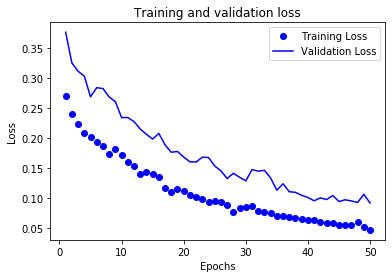

In [26]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss') #bo es para blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss') # b es para solid blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

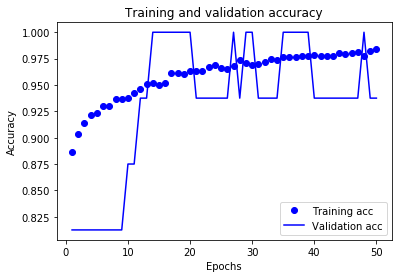

In [27]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Final test

In [3]:
from tensorflow.keras.models import load_model
model = load_model('xception_fine_tunned.h5')

In [5]:
test_dir = '/home/carlo/Documentos/Datasets/chest_xray/test'
IMAGE_SIZE = 299
batch_size = 4
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [7]:
import numpy as np

test_steps_per_epoch = np.ceil(test_generator.samples / batch_size)
results = model.evaluate_generator(test_generator, steps=test_steps_per_epoch)
print("Test Accuracy: ", results[1])

Test Accuracy:  0.9391026


### Confusion Matrix

In [8]:
true_labels = test_generator.classes
predicted_labels = model.predict(test_generator, steps=test_steps_per_epoch)

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, classification_report

In [14]:
predicted_labels = np.reshape(np.round(predicted_labels), [predicted_labels.shape[0]])
predicted_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
confusion_matrix(true_labels, predicted_labels)

array([[217,  17],
       [ 21, 369]])

\[\[true negatives, false negatives\],<br>
  \[false positives, true positives\]\]

In [16]:
precision_score(true_labels, predicted_labels)

0.9559585492227979

In [18]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       234
           1       0.96      0.95      0.95       390

    accuracy                           0.94       624
   macro avg       0.93      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624

